In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
batch_size = 128

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

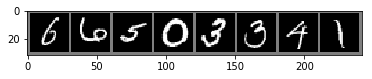

    6     6     5     0     3     3     4     1


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
print(' '.join('%5s' % labels[j].numpy() for j in range(8)))

In [4]:
nz = 100

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
class Generator(nn.Module):
    def __init__(self, nc=1, ngf=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input shape : (n, nz, 1, 1)
            nn.ConvTranspose2d(nz, ngf*8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            
            # input shape : (n, ngf*8, 7, 7)
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),            
            
            # input shape : (n, ngf*4, 14, 14)
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            # output shape : (n, 1, 28, 28)            
        
        )
    def forward(self, input):
        output = self.model(input)
        return output
    
netG = Generator().to(device)
netG.apply(weights_init)


Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input shape : (n, nc, 28, 28)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input shape : (n, ndf, 14, 14)
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),            
            
            # input shape : (n, ndf*2, 7, 7)
            nn.Conv2d(ndf*2, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.model(input)
        return output.view(-1,1).squeeze(1)
    
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)

In [6]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

[0] Loss_D: 2.1956  Loss_G: 1.1587


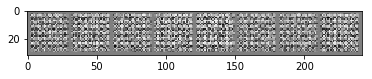

[1] Loss_D: 0.8187  Loss_G: 2.1378


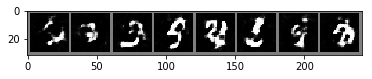

[2] Loss_D: 1.0409  Loss_G: 2.5701


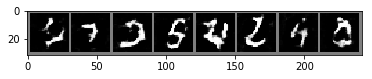

[3] Loss_D: 0.8043  Loss_G: 1.4190


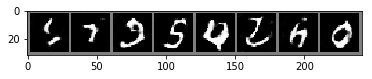

[4] Loss_D: 0.8609  Loss_G: 1.4116


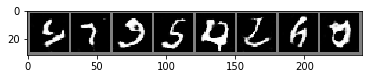

[5] Loss_D: 0.8977  Loss_G: 1.5869


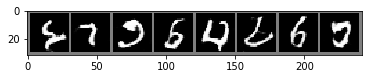

[6] Loss_D: 1.0011  Loss_G: 0.8320


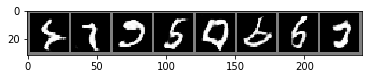

[7] Loss_D: 1.1154  Loss_G: 1.1812


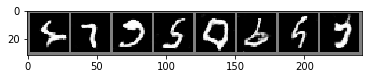

[8] Loss_D: 1.0040  Loss_G: 0.8332


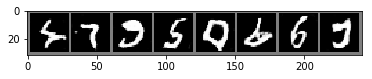

[9] Loss_D: 0.9486  Loss_G: 2.0162


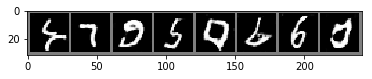

[10] Loss_D: 0.9709  Loss_G: 1.1508


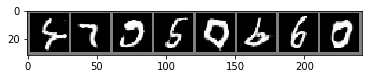

[11] Loss_D: 0.9468  Loss_G: 1.7385


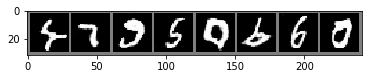

[12] Loss_D: 0.8504  Loss_G: 1.2565


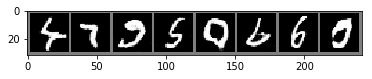

[13] Loss_D: 1.0527  Loss_G: 1.2390


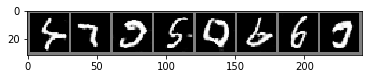

[14] Loss_D: 0.8067  Loss_G: 1.4100


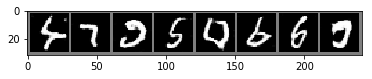

[15] Loss_D: 0.9368  Loss_G: 1.7592


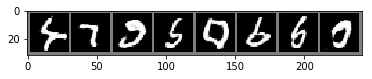

[16] Loss_D: 1.0054  Loss_G: 0.5856


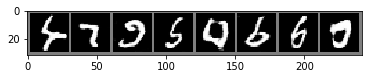

[17] Loss_D: 1.2515  Loss_G: 1.9880


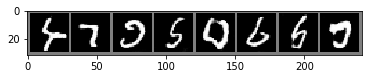

[18] Loss_D: 0.9832  Loss_G: 1.4587


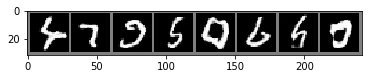

[19] Loss_D: 0.9423  Loss_G: 1.4321


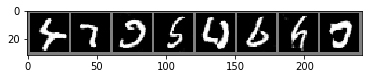

[20] Loss_D: 0.9830  Loss_G: 0.8062


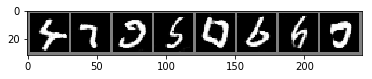

[21] Loss_D: 0.9113  Loss_G: 1.3217


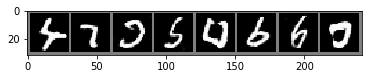

[22] Loss_D: 0.9198  Loss_G: 1.7758


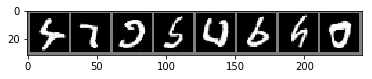

[23] Loss_D: 0.9598  Loss_G: 1.3216


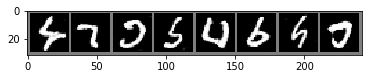

[24] Loss_D: 0.9753  Loss_G: 1.0587


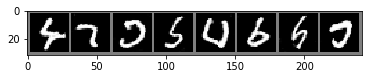

[25] Loss_D: 1.3880  Loss_G: 2.6750


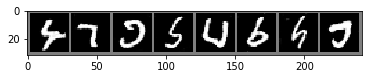

[26] Loss_D: 0.9313  Loss_G: 1.2689


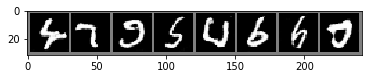

[27] Loss_D: 0.9297  Loss_G: 1.7615


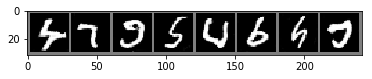

[28] Loss_D: 1.1368  Loss_G: 0.5506


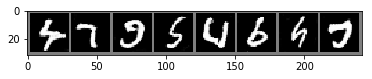

[29] Loss_D: 0.8897  Loss_G: 1.6813


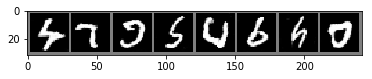

[30] Loss_D: 0.9601  Loss_G: 1.9370


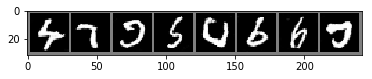

[31] Loss_D: 0.9340  Loss_G: 1.7053


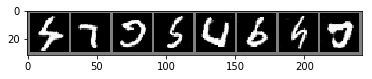

[32] Loss_D: 0.9865  Loss_G: 1.9191


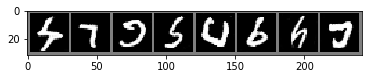

[33] Loss_D: 0.9704  Loss_G: 1.2794


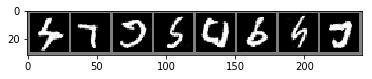

[34] Loss_D: 0.9508  Loss_G: 1.3021


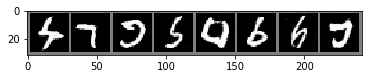

[35] Loss_D: 0.9463  Loss_G: 1.9318


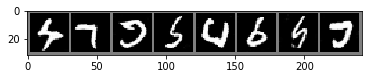

[36] Loss_D: 0.9360  Loss_G: 1.1917


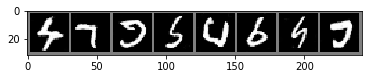

[37] Loss_D: 1.0933  Loss_G: 1.8312


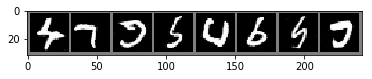

[38] Loss_D: 0.9192  Loss_G: 1.5130


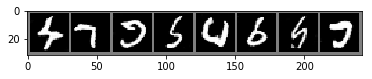

[39] Loss_D: 1.0146  Loss_G: 1.0377


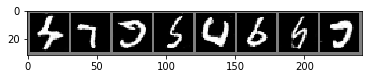

[40] Loss_D: 0.9633  Loss_G: 1.2335


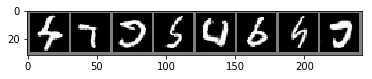

[41] Loss_D: 1.3558  Loss_G: 0.5250


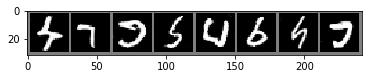

[42] Loss_D: 0.8843  Loss_G: 1.6737


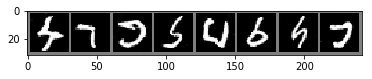

[43] Loss_D: 1.2318  Loss_G: 2.1231


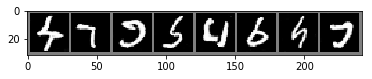

[44] Loss_D: 1.0705  Loss_G: 1.1158


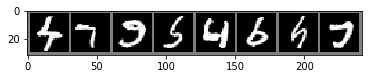

[45] Loss_D: 0.9905  Loss_G: 1.3323


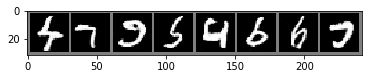

[46] Loss_D: 1.0534  Loss_G: 0.8215


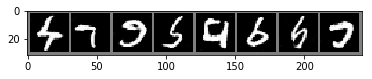

[47] Loss_D: 1.1275  Loss_G: 1.8991


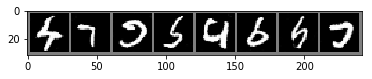

[48] Loss_D: 1.0168  Loss_G: 1.7987


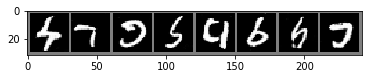

[49] Loss_D: 0.9185  Loss_G: 1.6019


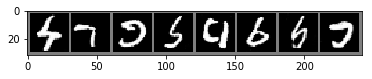

[50] Loss_D: 0.9561  Loss_G: 1.3266


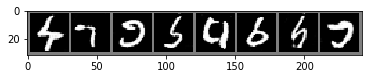

[51] Loss_D: 0.9711  Loss_G: 1.7321


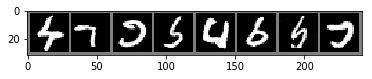

[52] Loss_D: 0.9281  Loss_G: 1.1756


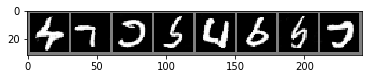

[53] Loss_D: 1.0468  Loss_G: 2.0207


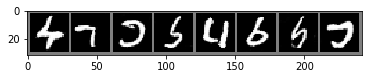

[54] Loss_D: 0.9702  Loss_G: 1.7136


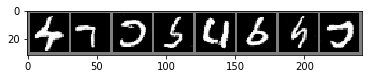

[55] Loss_D: 1.0249  Loss_G: 1.1509


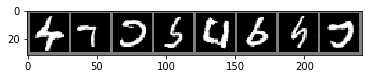

[56] Loss_D: 1.0065  Loss_G: 1.5632


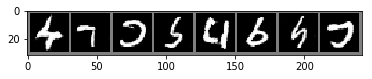

[57] Loss_D: 0.7865  Loss_G: 1.5032


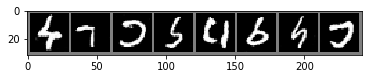

[58] Loss_D: 1.1090  Loss_G: 0.8345


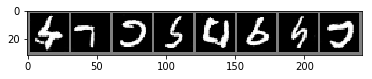

[59] Loss_D: 1.1021  Loss_G: 1.7584


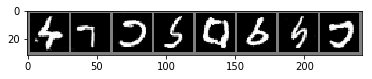

[60] Loss_D: 0.8481  Loss_G: 2.2888


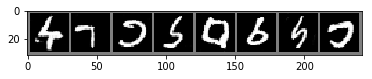

[61] Loss_D: 0.8383  Loss_G: 1.6752


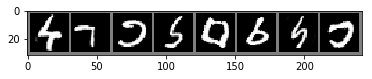

[62] Loss_D: 0.9786  Loss_G: 1.1273


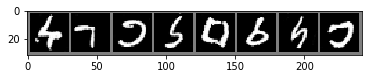

[63] Loss_D: 1.1589  Loss_G: 0.9263


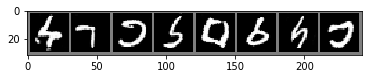

[64] Loss_D: 1.0129  Loss_G: 1.6038


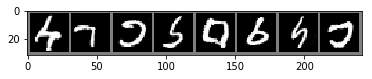

[65] Loss_D: 0.9629  Loss_G: 1.7992


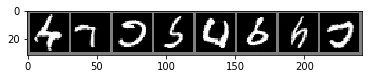

[66] Loss_D: 0.9445  Loss_G: 1.7373


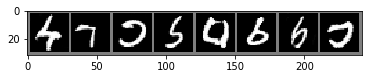

[67] Loss_D: 1.0818  Loss_G: 1.1241


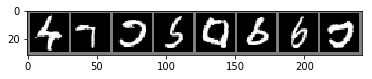

[68] Loss_D: 1.1195  Loss_G: 2.0052


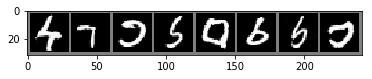

[69] Loss_D: 0.9635  Loss_G: 1.5148


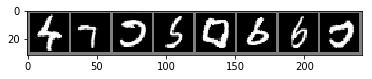

[70] Loss_D: 1.0720  Loss_G: 0.9106


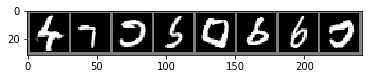

[71] Loss_D: 0.9208  Loss_G: 1.6619


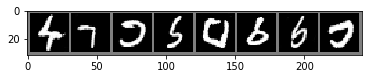

[72] Loss_D: 1.0025  Loss_G: 1.1283


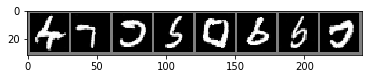

[73] Loss_D: 1.1070  Loss_G: 2.0749


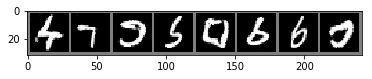

[74] Loss_D: 0.9213  Loss_G: 1.4961


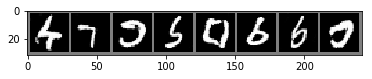

[75] Loss_D: 0.9707  Loss_G: 1.0044


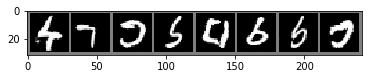

[76] Loss_D: 0.9555  Loss_G: 1.4930


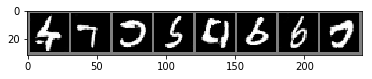

[77] Loss_D: 0.8721  Loss_G: 1.6449


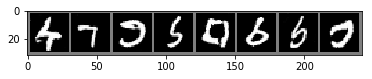

[78] Loss_D: 0.9133  Loss_G: 1.4096


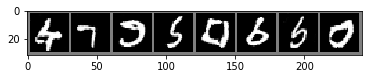

[79] Loss_D: 0.8927  Loss_G: 1.5170


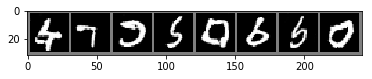

[80] Loss_D: 1.1293  Loss_G: 1.1546


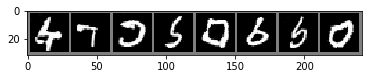

[81] Loss_D: 1.0196  Loss_G: 1.8360


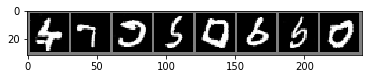

[82] Loss_D: 0.8441  Loss_G: 1.5445


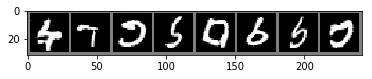

[83] Loss_D: 1.1303  Loss_G: 1.3167


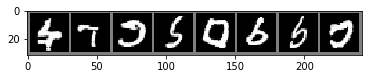

[84] Loss_D: 0.9411  Loss_G: 1.2711


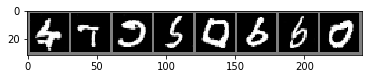

[85] Loss_D: 1.0222  Loss_G: 2.2840


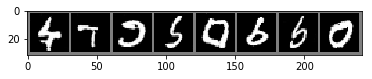

[86] Loss_D: 1.0474  Loss_G: 2.2323


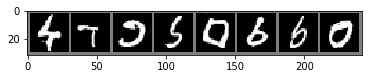

[87] Loss_D: 1.0725  Loss_G: 2.0942


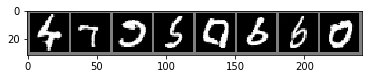

[88] Loss_D: 1.1588  Loss_G: 0.9473


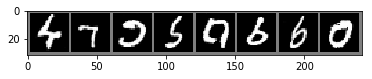

[89] Loss_D: 0.9767  Loss_G: 1.4866


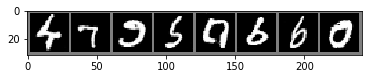

[90] Loss_D: 0.8890  Loss_G: 1.5342


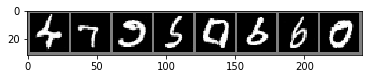

[91] Loss_D: 1.0512  Loss_G: 1.6621


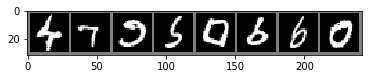

[92] Loss_D: 1.1134  Loss_G: 0.5982


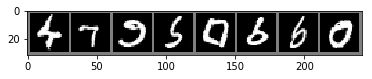

[93] Loss_D: 0.9970  Loss_G: 2.3434


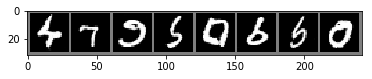

[94] Loss_D: 0.9994  Loss_G: 1.7454


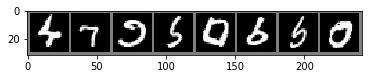

[95] Loss_D: 0.8723  Loss_G: 1.3527


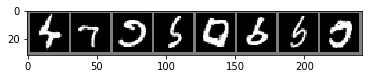

[96] Loss_D: 0.9102  Loss_G: 1.9283


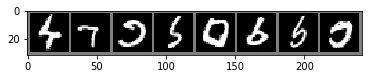

[97] Loss_D: 0.9718  Loss_G: 1.6249


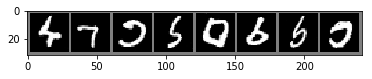

[98] Loss_D: 0.9534  Loss_G: 1.4258


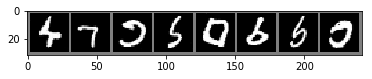

[99] Loss_D: 0.9275  Loss_G: 1.5319


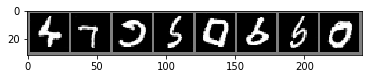

In [7]:
n_epoch = 100
n_show = 10000
n_save = 50

for epoch in range(n_epoch):
    for i, data in enumerate(trainloader, 0):
        # data[0] is images, data[1] is labels
        # Discriminator - real
        netD.zero_grad()
        
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        
        real_labels = torch.full((batch_size,), 0.9, device=device)
        g_real_labels = torch.full((batch_size,), 0.9, device=device)
        fake_labels = torch.full((batch_size,), 0, device=device)                
        
        
        output = netD(real_data)
        loss_d_real = criterion(output, real_labels)
        loss_d_real.backward()
        
        # Discriminator - fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        
        # detach G's output i.e. fake_data from D so G does not get backprop
        output = netD(fake_data.detach())
        loss_d_fake = criterion(output, fake_labels)
        loss_d_fake.backward()        
        
        # Discriminator - update 2 backprop
        optimizerD.step()
        
        loss_d_total = loss_d_real + loss_d_fake
        
        # Generator
        netG.zero_grad()
        output = netD(fake_data)
        loss_g = criterion(output, g_real_labels)
        loss_g.backward()
        
        optimizerG.step()
        
        
        # show image
        if i%n_show == 0:
            print('[%d] Loss_D: %.4f  Loss_G: %.4f'%(epoch, loss_d_total.item(), loss_g.item()))
            test_imgs = netG(fixed_noise)
            imshow(torchvision.utils.make_grid(test_imgs[0:8].detach().cpu()))
            
        if i%n_save == 0:
            torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % ('./models', epoch))
            torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % ('./models', epoch))